# Barotropic Streamfunction (MOM6-only)
 
This recipe demonstrates how to compute and plot the barotropic streamfunction ($\psi$) from MOM6 output.

The workflow is,
1. Load the MOM6 depth-integrated zonal mass transport (`umo_2d`).
2. Convert it to volume transport in Sverdrups (`Sv`).
3. Integrate meridionally (cumulative sum along latitude) to obtain the barotropic streamfunction ($\psi$).
4. Plot a circumpolar map with a circular boundary and land mask.

## Physical background

The barotropic streamfunction ($\psi$) is obtained from the integration of the velocity field starting from a physical boundary at which we know the transport is zero. The difference between to streamlines is a measure of the transport between them. 

There are different ways to calculate it depending on your choice of boundary for the integration. This notebook calculates it integrating in the meridional space, starting from the Antarctic continent using the zonal velocity field:

$$
\psi = \int_{y_{\rm Antarctica}}^{y} U \, \mathrm{d}y ,
$$

where $U = \int u \, \mathrm{dz}$ is the depth-integrated $u$-velocity.

### MOM6 settings

```python
expt = "panant-01-zstar-v13"
transport_var = "umo_2d" # zonal mass transport
bathy_var     = "deptho" # bathymetry
```
with,
- coordinates: `yh` (latitude) and `xh` (longitude)
- land mask: `deptho` is NaN over land.

### MOM5 settings
To adapt this recipe for MOM5 output, update the variables as follows,
```python
expt = "01deg_jra55v13_ryf9091"
transport_var = "tx_trans_int_z" # zonal mass transport
bathy_var     = "ht" # bathymetry
```
with,
- coordinates: `yt_ocean` (latitude) and `xt_ocean` (longitude)
- land mask: `ht` is NaN over land.

In [1]:
import warnings
import numpy as np
import xarray as xr
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import dask.distributed as dask
import intake
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
client = dask.Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34303,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46023,Total threads: 1
Dashboard: /proxy/45657/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:41641,


In [3]:
cat = intake.cat.access_nri
cat

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55_ryf_Control,{ACCESS-OM2-01},"{0.1° ACCESS-OM2 repeat year forcing control run for the simulations performed in Huguenin et al. (2024, GRL)}","{ocean, seaIce}","{1mon, fx}","{geolon_t, sss_m, total_ocean_sens_heat, aice_m, temp_advection, neutral, strength_m, fswup_m, temp_eta_smooth_on_nrho, time, time_bnds, scalar_axis, evap, strairx_m, total_net_sfc_heating, eta_gl..."
01deg_jra55_ryf_ENFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 El Níño run for the simulations performed in Huguenin et al. (2024, GRL)}","{ocean, seaIce}","{1mon, fx}","{geolon_t, sss_m, total_ocean_sens_heat, aice_m, temp_advection, neutral, strength_m, fswup_m, time, time_bnds, scalar_axis, evap, strairx_m, total_net_sfc_heating, eta_global, sw_edges_ocean, pot..."
01deg_jra55_ryf_LNFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 La Níña run for the simulations performed in Huguenin et al. (2024, GRL)}","{ocean, seaIce}","{1mon, fx}","{geolon_t, sss_m, total_ocean_sens_heat, aice_m, temp_advection, neutral, strength_m, fswup_m, time, time_bnds, scalar_axis, evap, strairx_m, total_net_sfc_heating, eta_global, sw_edges_ocean, pot..."
01deg_jra55v13_ryf9091,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{1mon, 3hr, 1day, 3mon, fx}","{yu_ocean_sub02, geolon_t, sss_m, total_ocean_sens_heat, aice_m, temp_advection, neutral, strength_m, fswup_m, rho, time, yt_ocean_sub01, scalar_axis, evap, strairx_m, total_net_sfc_heating, eta_g..."
01deg_jra55v13_ryf9091_easterlies_down10,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal/meridional wind speed around Antarctica decreased by 10%.},"{ocean, seaIce}","{1mon, fx, 1day}","{geolon_t, sss_m, total_ocean_sens_heat, aice_m, neutral, strength_m, fswup_m, time, scalar_axis, evap, strairx_m, eta_global, sw_edges_ocean, potrho, pot_rho_0, TLON, total_ocean_river, average_T..."
01deg_jra55v13_ryf9091_easterlies_up10,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal/meridional wind speed around Antarctica increased by 10%.},"{ocean, seaIce}","{1mon, fx, 1day}","{geolon_t, sss_m, total_ocean_sens_heat, aice_m, neutral, strength_m, fswup_m, time, scalar_axis, evap, strairx_m, eta_global, sw_edges_ocean, potrho, pot_rho_0, TLON, total_ocean_river, average_T..."
01deg_jra55v13_ryf9091_easterlies_up10_meridional,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and meridional wind speed around Antarctica increased by 10%.},"{ocean, seaIce}","{1mon, fx, 1day}","{geolon_t, sss_m, total_ocean_sens_heat, aice_m, neutral, strength_m, fswup_m, time, scalar_axis, evap, strairx_m, eta_global, sw_edges_ocean, potrho, pot_rho_0, TLON, total_ocean_river, average_T..."
01deg_jra55v13_ryf9091_easterlies_up10_zonal,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal wind speed around Antarctica increased by 10%.},"{ocean, seaIce}","{1mon, fx, 1day}","{geolon_t, sss_m, total_ocean_sens_heat, aice_m, neutral, strength_m, fswup_m, time, scalar_axis, evap, strairx_m, eta_global, sw_edges_ocean, potrho, pot_rho_0, TLON, total_ocean_river, average_T..."
01deg_jra55v13_ryf9091_qian_wthmp,{ACCESS-OM2},"{Future perturbations with wind, thermal and meltwater forcing, branching off 01deg_jra55v13_ryf9091, as described in Li et al. 2023, https://www.nature.com/articles/s41586-023-05762-w}","{ocean, seaIce}","{1mon, fx}","{geolon_t, sss_m, total_ocean_sens_heat, aice_m, temp_advection, strength_m, fswup_m, time, scalar_axis, evap, strairx_m, eta_global, sw_edges_ocean, potrho, pot_rho_0, TLON, total_ocean_river, av..."


In [4]:
expt = "panant-01-zstar-v13"
transport_var = "umo_2d"
bathy_var = "deptho"
freq = "1mon"
start_date_regex = r"203[5-9].*|204[0-9].*"
start_date = "2035-01-01"
end_date = "2050-01-01"
rho0 = 1035 #kg/m3
lat = "yh"
lon = "xq"

In [5]:
def load_mom6_zonal_mass_transport(transport_var: str, rho0: int|float) -> xr.DataArray:
    """
    Load mom6 zonal mass transport, and convert it to Sverdrups
    """
    mass_transport = (
        cat[expt]
        .search(variable=transport_var,
                start_date=start_date_regex,
                frequency=freq)
        .to_dask(xarray_open_kwargs={
            "chunks":{"time": 3},
            "decode_timedelta": False})[transport_var]
        .sel(time=slice(start_date, end_date))
    )

    # convert to volume transport (m^3/s)
    volume_transport = mass_transport / rho0

    # convert to Sverdrups
    volume_transport = volume_transport / 1e6
    volume_transport.attrs["units"] = "Sv"
    return volume_transport

def get_land_mask(bathy_var: str)-> xr.DataArray:
    """
    1 = ocean, Nan = land
    """
    mask = (
        cat[expt]
        .search(variable=bathy_var)
        .to_dask(xarray_open_kwargs={
            "chunks":{"time": 3}})[bathy_var]
    )
    return xr.where(np.isnan(mask), 1, np.nan).rename("land_mask")

def calculate_streamfunction(transport_var, rho0, lat) -> xr.DataArray:
    """
    Compute barotropic streamfunction (Sv)
    """
    volume_transport = load_mom6_zonal_mass_transport(transport_var, rho0)
    psi = volume_transport.cumsum(dim=lat)
    psi.name = "psi"
    psi.attrs["standard_name"] = "Barotropic streamfunction"
    psi.attrs["units"] = "Sv"
    return psi

def circumpolar_map():
    """
    Set up South Polar Stereo map with circular boundary.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -80, -40], crs=ccrs.PlateCarree())
    ax.set_facecolor("lightgrey")

    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    return fig, ax

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


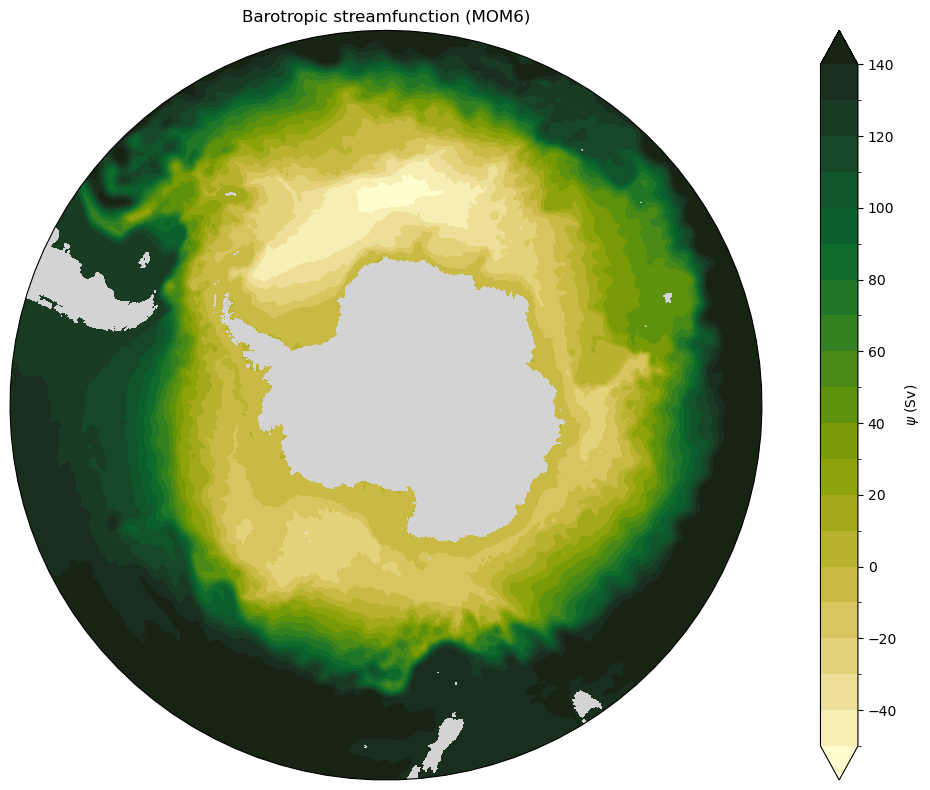

In [6]:
psi = calculate_streamfunction(transport_var, rho0, lat)
psi_mean = psi.mean(dim="time").load()
land_mask = get_land_mask(bathy_var)

fig, ax = circumpolar_map()
levels = np.arange(-50, 150, 10) # levels used in contour plots

psi_mean.plot.contourf(
    ax=ax,
    x=lon,
    y=lat,
    transform=ccrs.PlateCarree(),
    levels=levels,
    extend="both",
    cmap=cmocean.cm.speed,
    cbar_kwargs={"label": r"$\psi$ (Sv)"},
)

land_mask.plot.contourf(
    ax=ax,
    colors="lightgrey",
    add_colorbar=False,
    zorder=2,
    transform=ccrs.PlateCarree(),
)

plt.title("Barotropic streamfunction (MOM6)")
plt.tight_layout()
plt.show()